# COMP7015 Lab 4: Basic Generative Models



## Overview
This notebook explores key concepts in generative models through hands-on implementations:
- **Setup & Prerequisites**: Environment configuration and dependencies
- **Convolutional Autoencoders**: Image denoising implementation
- **Sequence-to-Sequence Models**: Natural language processing with and without attention


## 1. Environment Setup and Dependencies

This section consolidates all package installations and imports needed throughout the notebook. We use environment checks to avoid redundant installations and organize imports by functionality.

## 1.1 Centralized Setup

This section consolidates all package installations, imports, device configuration, and global settings into a single location for improved organization and reproducibility across the notebook.

In [1]:
# ===============================================
# Windows Compatibility Guide
# ===============================================

# This notebook includes several shell commands that might not work on Windows.
# Below are Windows-compatible alternatives:

import platform
import subprocess
import os

def run_platform_command(unix_cmd, windows_cmd=None, powershell_cmd=None):
    """
    Run platform-specific commands with fallbacks for Windows
    """
    system = platform.system()

    if system == "Windows":
        if powershell_cmd:
            print(f"Windows PowerShell: {powershell_cmd}")
            return subprocess.run(["powershell", "-Command", powershell_cmd], capture_output=True, text=True)
        elif windows_cmd:
            print(f"Windows cmd: {windows_cmd}")
            return subprocess.run(windows_cmd, shell=True, capture_output=True, text=True)
        else:
            print(f"Unix command not compatible with Windows: {unix_cmd}")
            print("Please install WSL (Windows Subsystem for Linux) or use alternatives")
            return None
    else:
        print(f"Unix/Linux: {unix_cmd}")
        return subprocess.run(unix_cmd, shell=True, capture_output=True, text=True)

# Example usage for common commands used in this notebook:
print("Platform-specific command examples:")
print("\n1. Installing packages (already handled by subprocess in check_and_install)")
print("2. Curl commands -> Use requests library or PowerShell Invoke-WebRequest")
print("3. File operations -> Use Python os/pathlib instead of shell commands")

# For Windows users running shell commands in this notebook:
print("\n📝 Windows Users: When you see '!' commands, you can:")
print("   • Install WSL2 (Windows Subsystem for Linux) - Recommended")
print("   • Use PowerShell equivalents shown in comments")
print("   • Use built-in Python alternatives where provided")

Platform-specific command examples:

1. Installing packages (already handled by subprocess in check_and_install)
2. Curl commands -> Use requests library or PowerShell Invoke-WebRequest
3. File operations -> Use Python os/pathlib instead of shell commands

📝 Windows Users: When you see '!' commands, you can:
   • Install WSL2 (Windows Subsystem for Linux) - Recommended
   • Use PowerShell equivalents shown in comments
   • Use built-in Python alternatives where provided


### 1.2 Dataset Preparation
We use standard benchmarks that are small enough for educational purposes but complex enough to demonstrate key concepts.


MNIST train set  ➜  60,000 images
Single image tensor shape: torch.Size([1, 28, 28])  |  Label example: 5


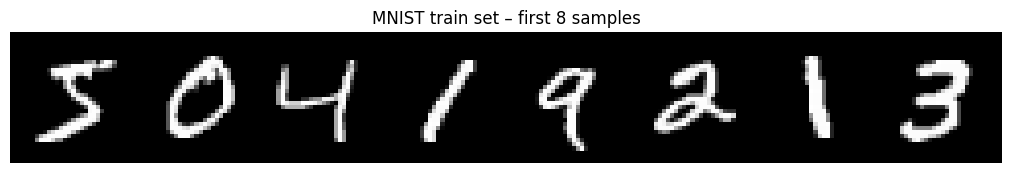

Labels: [5, 0, 4, 1, 9, 2, 1, 3]

Fashion-MNIST train set  ➜  60,000 images
Single image tensor shape: torch.Size([1, 28, 28])  |  Label example: 9


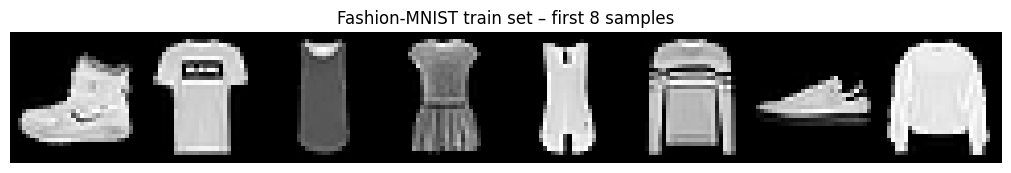

Labels: [9, 0, 0, 3, 0, 2, 7, 2]


In [2]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Download datasets automatically
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='data', train=True, download=True, transform=transform)
fashion_train = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)

def describe_and_show(dataset, name, n_show=8):
    """Print dataset info and display `n_show` sample images."""
    print(f"\n{name}  ➜  {len(dataset):,} images")
    print(f"Single image tensor shape: {dataset[0][0].shape}  |  Label example: {dataset[0][1]}")

    # ---- prepare a mini-batch of n_show items ----
    imgs   = torch.stack([dataset[i][0] for i in range(n_show)])
    labels = [dataset[i][1] for i in range(n_show)]

    # ---- show them in one grid ----
    grid = make_grid(imgs, nrow=n_show, padding=2, normalize=True)
    plt.figure(figsize=(n_show * 1.6, 1.8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f"{name} – first {n_show} samples")
    plt.axis("off")
    plt.show()
    print(f"Labels: {labels}")

# Run the helper for both datasets
describe_and_show(mnist_train,    "MNIST train set")
describe_and_show(fashion_train,  "Fashion-MNIST train set")

## 2. Convolutional Autoencoder (CAE) – Image Denoising
### 2.1 Understanding Autoencoder Architecture
What is an Autoencoder?

An autoencoder is a neural network designed to learn efficient representations of data through an encoder-decoder architecture. It's trained to reconstruct its input, forcing it to learn compressed, meaningful representations

**Architecture Components:**

* Encoder: Compresses input data into a lower-dimensional latent representation

* Bottleneck: The compressed representation (latent space)

* Decoder: Reconstructs the original input from the compressed representation

* Reconstruction Loss: Measures how well the decoder recreates the original input

**Why Convolutional Layers?**

* For image data, convolutional layers are superior because they:

* Preserve spatial relationships between pixels

* Share parameters across the image (translation invariance)

* Reduce the number of parameters compared to fully connected layers

* Learn hierarchical features from edges to complex patterns

### 2.2 Denoising Application
**Why Denoising?**

Image denoising demonstrates the autoencoder's ability to separate signal from noise, learning the essential features that represent the true image structure.

**The Learning Process:**

1. Input: Noisy image (original + random noise)
2. Target: Clean original image
3. Learning: Network learns to ignore noise and reconstruct clean features
4. Result: Denoised image that preserves important details

### 2.3 Implementation with Detailed Explanations

In [3]:
import time, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on", device.upper())

# ─── Dataset with on-the-fly Gaussian noise ─────────────────────────────────
class NoisyFashion(datasets.FashionMNIST):
    def __init__(self, root, train=True, noise_factor=0.4):
        tf = transforms.ToTensor()
        super().__init__(root, train=train, download=True, transform=tf)
        self.noise = noise_factor
    def __getitem__(self, idx):
        clean, _ = super().__getitem__(idx)
        noisy = (clean + self.noise * torch.randn_like(clean)).clamp(0., 1.)
        return noisy, clean            # (input , target)

train_loader = DataLoader(NoisyFashion("data", True), 128, shuffle=True)
test_loader  = DataLoader(NoisyFashion("data", False), 128, shuffle=False)

# ─── 2-layer encoder / decoder 28→7→28 ─────────────────────────────────────
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # 28×28 ➜ 14×14 ➜ 7×7
        self.enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1), nn.ReLU(True),      # 28→14
            nn.Conv2d(16, 32, 3, 2, 1), nn.ReLU(True)      # 14→7
        )
        # 7×7 ➜ 14×14 ➜ 28×28
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 2, 1, 1), nn.ReLU(True),  # 7→14
            nn.ConvTranspose2d(16,  1, 3, 2, 1, 1), nn.Sigmoid()    # 14→28
        )
    def forward(self, x): return self.dec(self.enc(x))

model     = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimiser = optim.Adam(model.parameters(), lr=1e-3)
print("Total params :", sum(p.numel() for p in model.parameters()))

Running on CPU
Total params : 9569


In [4]:
# ─── Training ──────────────────────────────────────────────────────────────
EPOCHS, LOG_EVERY = 8, 150
print("\n🚀 Training …")
for ep in range(1, EPOCHS + 1):
    model.train(); running = 0
    for i, (noisy, clean) in enumerate(train_loader, 1):
        noisy, clean = noisy.to(device), clean.to(device)
        optimiser.zero_grad()
        loss = criterion(model(noisy), clean)
        loss.backward(); optimiser.step()
        running += loss.item()
        if i % LOG_EVERY == 0:
            print(f"Epoch {ep}/{EPOCHS}  batch {i:4d}/{len(train_loader)}  "
                  f"mean-MSE {running/LOG_EVERY:.4f}")
            running = 0
    print("-"*55)


🚀 Training …
Epoch 1/8  batch  150/469  mean-MSE 0.0824
Epoch 1/8  batch  300/469  mean-MSE 0.0208
Epoch 1/8  batch  450/469  mean-MSE 0.0181
-------------------------------------------------------
Epoch 2/8  batch  150/469  mean-MSE 0.0171
Epoch 2/8  batch  300/469  mean-MSE 0.0165
Epoch 2/8  batch  450/469  mean-MSE 0.0161
-------------------------------------------------------
Epoch 3/8  batch  150/469  mean-MSE 0.0157
Epoch 3/8  batch  300/469  mean-MSE 0.0155
Epoch 3/8  batch  450/469  mean-MSE 0.0154
-------------------------------------------------------
Epoch 4/8  batch  150/469  mean-MSE 0.0151
Epoch 4/8  batch  300/469  mean-MSE 0.0150
Epoch 4/8  batch  450/469  mean-MSE 0.0148
-------------------------------------------------------
Epoch 5/8  batch  150/469  mean-MSE 0.0147
Epoch 5/8  batch  300/469  mean-MSE 0.0146
Epoch 5/8  batch  450/469  mean-MSE 0.0145
-------------------------------------------------------
Epoch 6/8  batch  150/469  mean-MSE 0.0144
Epoch 6/8  batch  


📊 Final Test MSE: 0.0138


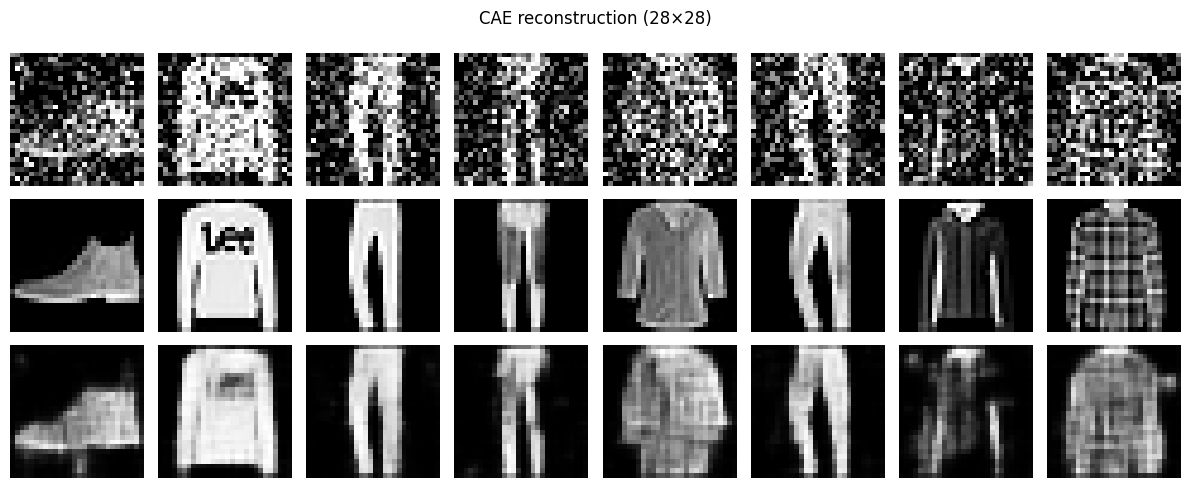

In [5]:
# ─── Quick visual check ────────────────────────────────────────────────────
model.eval()
with torch.no_grad():
    noisy, clean = next(iter(test_loader))
    recon = model(noisy.to(device)).cpu()
    test_mse = criterion(model(noisy), clean)
    print(f"\n📊 Final Test MSE: {test_mse:.4f}")

fig, ax = plt.subplots(3, 8, figsize=(12, 5))
labels = ["Noisy", "Clean", "Denoised"]
for col in range(8):
    ax[0, col].imshow(noisy [col].squeeze(), cmap="gray"); ax[0, col].axis("off")
    ax[1, col].imshow(clean [col].squeeze(), cmap="gray"); ax[1, col].axis("off")
    ax[2, col].imshow(recon [col].squeeze(), cmap="gray"); ax[2, col].axis("off")
for r, t in enumerate(labels): ax[r, 0].set_ylabel(t)
plt.suptitle("CAE reconstruction (28×28)"); plt.tight_layout(); plt.show()

<font color='red'>*<b>Open Question</b>*: How does changing noise_factor from 0.4 to 0.8 affect the final MSE and visuals? Explain why the results are different or same.</font>

## 3. Sequence-to-Sequence (Seq2Seq) Model – Simple Case: From English to Pig Latin

### 3.1 Understanding Seq2Seq Architecture

What is a Sequence-to-Sequence Model?
A seq2seq model is designed to convert input sequences of variable length into output sequences of potentially different lengths. This architecture is fundamental for tasks like machine translation, text summarization, and conversational AI.

Core Components:
• Encoder: Processes the input sequence and compresses it into a context vector
• Context Vector: Fixed-size representation of the input sequence
• Decoder: Generates the output sequence step by step using the context vector
• Attention Mechanism: Allows the decoder to focus on relevant parts of the input


### 3.2 Encoder-Decoder Architecture
Architecture Explanation:

* Encoder: Processes input sequence word by word, building hidden representations

* Decoder: Generates output sequence one word at a time using encoder's final state

* Teacher Forcing: During training, uses ground truth words as input (not predictions)

* Hidden State Transfer: Encoder's final state initializes decoder's first state



In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

# ============================================================
# 3.2 VOCABULARY AND DEVICE SETUP BEFORE MODEL INITIALIZATION
# ============================================================

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Define special tokens and minimal vocabulary
SOS_TOKEN = 0  # Start of sentence
EOS_TOKEN = 1  # End of sentence
PAD_TOKEN = 2  # Padding token

# Source vocabulary (English)
src_vocab = {
    '<sos>': SOS_TOKEN,
    '<eos>': EOS_TOKEN,
    '<pad>': PAD_TOKEN,
    'i': 3, 'like': 4, 'machine': 5, 'learning': 6,
    'deep': 7, 'neural': 8, 'networks': 9, 'are': 10,
    'powerful': 11, 'is': 12, 'fun': 13
}

# Target vocabulary (Pig Latin)
tgt_vocab = {
    '<sos>': SOS_TOKEN,
    '<eos>': EOS_TOKEN,
    '<pad>': PAD_TOKEN,
    'iway': 3, 'ikelay': 4, 'achinemay': 5, 'earninglay': 6,
    'eepday': 7, 'euralnay': 8, 'etworksnay': 9, 'areway': 10,
    'owerfuplay': 11, 'isway': 12, 'unfay': 13
}

# Create reverse mappings (index to word)
tgt_idx2word = {v: k for k, v in tgt_vocab.items()}

print(f"Source vocab size: {len(src_vocab)}")
print(f"Target vocab size: {len(tgt_vocab)}")

# Simple toy dataset for demonstration
def to_pig_latin(word):
    """Convert English word to Pig Latin"""
    vowels = 'aeiouAEIOU'
    if word[0] in vowels:
        return word + 'way'
    else:
        return word[1:] + word[0] + 'ay'

# Create simple training dataset
dataset = [
    (['i', 'like', 'machine', 'learning'], ['iway', 'ikelay', 'achinemay', 'earninglay']),
    (['deep', 'learning', 'is', 'fun'], ['eepday', 'earninglay', 'isway', 'unfay']),
    (['neural', 'networks', 'are', 'powerful'], ['euralnay', 'etworksnay', 'areway', 'owerfuplay']),
    (['machine', 'learning', 'is', 'powerful'], ['achinemay', 'earninglay', 'isway', 'owerfuplay']),
    (['deep', 'neural', 'networks'], ['eepday', 'euralnay', 'etworksnay']),
    (['i', 'like', 'deep', 'learning'], ['iway', 'ikelay', 'eepday', 'earninglay'])
]

print(f"Training dataset size: {len(dataset)}")
print("Sample data:")
for i, (src, tgt) in enumerate(dataset[:2]):
    print(f"  {i+1}. {' '.join(src)} -> {' '.join(tgt)}")

Device: cpu
Source vocab size: 14
Target vocab size: 14
Training dataset size: 6
Sample data:
  1. i like machine learning -> iway ikelay achinemay earninglay
  2. deep learning is fun -> eepday earninglay isway unfay


In [7]:
# ============================================================
# MODEL ARCHITECTURE DEFINITIONS
# ============================================================

class Encoder(nn.Module):
    """RNN Encoder for sequence-to-sequence model"""
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # Embedding layer converts word indices to dense vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM layer for sequential processing
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)

    def forward(self, input_seq):
        # input_seq shape: (batch_size, seq_len)
        embedded = self.embedding(input_seq)  # (batch_size, seq_len, embedding_dim)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell

class Decoder(nn.Module):
    """RNN Decoder for sequence-to-sequence model"""
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_token, hidden, cell):
        # input_token shape: (batch_size, 1)
        embedded = self.embedding(input_token)  # (batch_size, 1, embedding_dim)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc(output)  # (batch_size, 1, vocab_size)
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    """Complete Sequence-to-Sequence model"""
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        tgt_len = tgt.size(1)
        tgt_vocab_size = self.decoder.fc.out_features

        # Encode source sequence
        encoder_outputs, hidden, cell = self.encoder(src)

        # Initialize decoder input with SOS token
        decoder_input = tgt[:, 0:1]  # First token is SOS
        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)

        # Decode step by step
        for t in range(1, tgt_len):
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            outputs[:, t:t+1] = output

            # Teacher forcing: use ground truth or predicted token
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(2)
            decoder_input = tgt[:, t:t+1] if teacher_force else top1

        return outputs

In [8]:
# Model hyperparameters
embedding_dim = 16
hidden_dim = 32
num_layers = 1

print("\n" + "="*60)
print("MODEL INITIALIZATION")
print("="*60)

# Initialize models
encoder = Encoder(len(src_vocab), embedding_dim, hidden_dim, num_layers)
decoder = Decoder(len(tgt_vocab), embedding_dim, hidden_dim, num_layers)
model = Seq2Seq(encoder, decoder, device).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total model parameters: {total_params:,}")
print(f"Encoder parameters: {sum(p.numel() for p in encoder.parameters()):,}")
print(f"Decoder parameters: {sum(p.numel() for p in decoder.parameters()):,}")

# Model architecture summary
print(f"\nModel Architecture:")
print(f"- Embedding dimension: {embedding_dim}")
print(f"- Hidden dimension: {hidden_dim}")
print(f"- Number of layers: {num_layers}")
print(f"- Source vocabulary size: {len(src_vocab)}")
print(f"- Target vocabulary size: {len(tgt_vocab)}")


MODEL INITIALIZATION
Total model parameters: 13,710
Encoder parameters: 6,624
Decoder parameters: 7,086

Model Architecture:
- Embedding dimension: 16
- Hidden dimension: 32
- Number of layers: 1
- Source vocabulary size: 14
- Target vocabulary size: 14


### 3.3 Training Process

Training Explanation:

* Batch Preparation: Converts words to indices and pads sequences

* Loss Function: Cross-entropy loss ignoring padding tokens

* Teacher Forcing: Uses ground truth words during training for stability

* Gradient Clipping: Prevents exploding gradients common in RNNs



In [10]:
def prepare_batch(batch_data, src_vocab, tgt_vocab, device):
    """Convert batch of sentence pairs to tensor format"""
    src_sentences = []
    tgt_sentences = []

    for src_words, tgt_words in batch_data:
        # Convert words to indices
        src_indices = [src_vocab['<sos>']] + [src_vocab[word] for word in src_words] + [src_vocab['<eos>']]
        tgt_indices = [tgt_vocab['<sos>']] + [tgt_vocab[word] for word in tgt_words] + [tgt_vocab['<eos>']]

        src_sentences.append(src_indices)
        tgt_sentences.append(tgt_indices)

    # Pad sequences to same length
    max_src_len = max(len(seq) for seq in src_sentences)
    max_tgt_len = max(len(seq) for seq in tgt_sentences)

    src_padded = []
    tgt_padded = []

    for src_seq, tgt_seq in zip(src_sentences, tgt_sentences):
        src_padded.append(src_seq + [src_vocab['<pad>']] * (max_src_len - len(src_seq)))
        tgt_padded.append(tgt_seq + [tgt_vocab['<pad>']] * (max_tgt_len - len(tgt_seq)))

    return torch.tensor(src_padded).to(device), torch.tensor(tgt_padded).to(device)

def train_seq2seq(model, dataset, src_vocab, tgt_vocab, num_epochs=100):
    """Train the sequence-to-sequence model"""

    criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<pad>'])
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()

    for epoch in range(num_epochs):
        total_loss = 0

        # Shuffle dataset
        random.shuffle(dataset)

        for i in range(0, len(dataset), 4):  # Batch size = 4
            batch = dataset[i:i+4]
            src_tensor, tgt_tensor = prepare_batch(batch, src_vocab, tgt_vocab, device)

            optimizer.zero_grad()

            # Forward pass
            output = model(src_tensor, tgt_tensor)

            # Reshape for loss calculation
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)  # Remove <sos> predictions
            tgt = tgt_tensor[:, 1:].reshape(-1)  # Remove <sos> from targets

            # Calculate loss
            loss = criterion(output, tgt)
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            total_loss += loss.item()

        if (epoch + 1) % 20 == 0:
            avg_loss = total_loss / len(dataset)
            print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

# Train the model
print("Training sequence-to-sequence model...")
train_seq2seq(model, dataset, src_vocab, tgt_vocab, num_epochs=300)


Training sequence-to-sequence model...
Epoch [20/300], Average Loss: 0.1619
Epoch [40/300], Average Loss: 0.1106
Epoch [60/300], Average Loss: 0.0736
Epoch [80/300], Average Loss: 0.0481
Epoch [100/300], Average Loss: 0.0357
Epoch [120/300], Average Loss: 0.0265
Epoch [140/300], Average Loss: 0.0208
Epoch [160/300], Average Loss: 0.0165
Epoch [180/300], Average Loss: 0.0135
Epoch [200/300], Average Loss: 0.0115
Epoch [220/300], Average Loss: 0.0097
Epoch [240/300], Average Loss: 0.0082
Epoch [260/300], Average Loss: 0.0071
Epoch [280/300], Average Loss: 0.0065
Epoch [300/300], Average Loss: 0.0058


### 3.4 Inference and Evaluation

In [11]:
# Missing to_pig_latin function definition (needed for expected outputs)
def to_pig_latin(word):
    """Convert English word to Pig Latin"""
    vowels = 'aeiouAEIOU'
    if word[0] in vowels:
        return word + 'way'
    else:
        return word[1:] + word[0] + 'ay'

def translate_sentence(model, sentence, src_vocab, tgt_vocab, tgt_idx2word, max_length=20):
    """Translate a sentence using the trained model"""
    model.eval()

    # Prepare input
    words = sentence.split()
    src_indices = [src_vocab['<sos>']] + [src_vocab.get(word, src_vocab['<sos>']) for word in words] + [src_vocab['<eos>']]
    src_tensor = torch.tensor(src_indices).unsqueeze(0).to(device)

    with torch.no_grad():
        # Encode
        encoder_outputs, hidden, cell = model.encoder(src_tensor)

        # Fix tensor dimensions for decoder - squeeze out batch dimension for single sequence
        hidden = hidden.squeeze(1)  # Remove batch dimension: (1, 1, 32) -> (1, 32)
        cell = cell.squeeze(1)      # Remove batch dimension: (1, 1, 32) -> (1, 32)

        # Decode
        decoder_input = torch.tensor([tgt_vocab['<sos>']]).unsqueeze(0).to(device)  # (1, 1)
        translated_words = []

        for _ in range(max_length):
            output, hidden, cell = model.decoder(decoder_input, hidden.unsqueeze(0), cell.unsqueeze(0))
            predicted_id = output.argmax(2).item()

            if predicted_id == tgt_vocab['<eos>']:
                break

            if predicted_id in tgt_idx2word:
                predicted_word = tgt_idx2word[predicted_id]
                translated_words.append(predicted_word)

            decoder_input = torch.tensor([predicted_id]).unsqueeze(0).to(device)
            # Update hidden states for next iteration
            hidden = hidden.squeeze(0)
            cell = cell.squeeze(0)

    return ' '.join(translated_words)

# Test translation
test_sentences = [
    "i like machine learning",
    "deep learning is fun",
    "neural networks are powerful"
]

print("\n=== TRANSLATION RESULTS ===")
for sentence in test_sentences:
    translation = translate_sentence(model, sentence, src_vocab, tgt_vocab, tgt_idx2word)
    expected = ' '.join([to_pig_latin(word) for word in sentence.split()])
    print(f"Input: {sentence}")
    print(f"Expected: {expected}")
    print(f"Model output: {translation}")
    print(f"Correct: {'✓' if translation == expected else '✗'}")
    print("-" * 40)

print("✅ Seq2Seq model successfully trained and tested")


=== TRANSLATION RESULTS ===
Input: i like machine learning
Expected: iway ikelay achinemay earninglay
Model output: iway ikelay achinemay earninglay
Correct: ✓
----------------------------------------
Input: deep learning is fun
Expected: eepday earninglay isway unfay
Model output: eepday earninglay isway unfay
Correct: ✓
----------------------------------------
Input: neural networks are powerful
Expected: euralnay etworksnay areway owerfulpay
Model output: euralnay etworksnay areway owerfuplay
Correct: ✗
----------------------------------------
✅ Seq2Seq model successfully trained and tested


## 4. Sequence-to-Sequence (Seq2Seq) with Attention

This section was adopted from adapted from https://docs.pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html.

### 4.1 The Attention Mechanism

The Bottleneck Problem: Traditional seq2seq models compress the entire input sequence into a single fixed-size vector, which becomes problematic for long sequences as important information can be lost.

How Attention Solves This: Instead of using only the final encoder state, attention allows the decoder to access all encoder hidden states, creating a dynamic context vector for each decoding step.

Attention Process:
• Alignment Scores: Calculate similarity between decoder state and each encoder state
• Attention Weights: Normalize scores using softmax to get probabilities
• Context Vector: Weighted sum of encoder states using attention weights
• Decoder Input: Combine context vector with previous decoder output

In [12]:
import unicodedata
import re
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import torch.nn.functional as F

### 4.2 Data Preparation
📌 Download the data from https://download.pytorch.org/tutorial/data.zip, and save the unzipped file to the same directory with this working space.

In [13]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [14]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [15]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [16]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [17]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
['nous sommes toutes en securite', 'we re all safe']


### 4.3 Model Construction

A Recurrent Neural Network, or RNN, is a network that operates on a sequence and uses its own output as input for subsequent steps.

A Sequence to Sequence network, or seq2seq network, or Encoder Decoder network, is a model consisting of two RNNs called the encoder and decoder. The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence.

Unlike sequence prediction with a single RNN, where every input corresponds to an output, the seq2seq model frees us from sequence length and order, which makes it ideal for translation between two languages.

Consider the sentence Je ne suis pas le chat noir → I am not the black cat. Most of the words in the input sentence have a direct translation in the output sentence, but are in slightly different orders, e.g. chat noir and black cat. Because of the ne/pas construction there is also one more word in the input sentence. It would be difficult to produce a correct translation directly from the sequence of input words.

With a seq2seq model the encoder creates a single vector which, in the ideal case, encodes the “meaning” of the input sequence into a single vector — a single point in some N dimensional space of sentences.

In [18]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [19]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

### 4.4 Attention Decoder

If only the context vector is passed between the encoder and decoder, that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs. First we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result (called attn_applied in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

Calculating the attention weights is done with another feed-forward layer attn, using the decoder’s input and hidden state as inputs. Because there are sentences of all sizes in the training data, to actually create and train this layer we have to choose a maximum sentence length (input length, for encoder outputs) that it can apply to. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.

In this tutorial, we will be using Bahdanau attention. However, it would be a valuable exercise to explore modifying the attention mechanism to use Luong attention.

In [20]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

### 4.5 Training

To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.

In [21]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [22]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [23]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [24]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting is done with matplotlib, using the array of loss values plot_losses saved while training.

In [25]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [26]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
0m 35s (- 8m 53s) (5 6%) 1.5431
1m 11s (- 8m 17s) (10 12%) 0.6752
1m 46s (- 7m 41s) (15 18%) 0.3491
2m 21s (- 7m 5s) (20 25%) 0.1934
2m 57s (- 6m 30s) (25 31%) 0.1192
3m 33s (- 5m 55s) (30 37%) 0.0817
4m 8s (- 5m 19s) (35 43%) 0.0623
4m 44s (- 4m 44s) (40 50%) 0.0516
5m 20s (- 4m 8s) (45 56%) 0.0443
5m 56s (- 3m 33s) (50 62%) 0.0399
6m 32s (- 2m 58s) (55 68%) 0.0369
7m 9s (- 2m 23s) (60 75%) 0.0341
7m 46s (- 1m 47s) (65 81%) 0.0326
8m 23s (- 1m 11s) (70 87%) 0.0309
8m 59s (- 0m 35s) (75 93%) 0.0301
9m 35s (- 0m 0s) (80 100%) 0.0291


### 4.6 Evaluation

Evaluation is mostly the same as training, but there are no targets so we simply feed the decoder’s predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder’s attention outputs for display later.

In [29]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn
    
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [30]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> j apprends vite
= i m a fast learner
< i m a fast learner <EOS>

> je suis suffisamment grand
= i m old enough
< i am poor tall <EOS>

> je suis sur le point de quitter ici
= i am about to leave here
< i am about to leave here <EOS>

> elles vous cherchent
= they re looking for you
< you re looking for you <EOS>

> il a l habitude de ce genre de situation
= he is used to that type of situation
< he is used to such situations <EOS>

> elle est accoutumee a veiller toute la nuit
= she is used to staying up all night
< she is used to staying up all night <EOS>

> je ne cours pas le moindre danger
= i m not in any danger
< i m not in any danger <EOS>

> nous sommes seules ici
= we re alone here
< we re alone here here <EOS>

> vous etes tres avise
= you re very wise
< you re very wise <EOS>

> elles sont bonnes toutes les deux
= they are both good
< they are both good <EOS>

